# Advanced Model: Prophet (by Meta)

In this notebook, we forecast the fastest Bitcoin transaction fee (sats/vByte) over a 24-hour horizon using the **Prophet model**, a decomposable time series framework developed by Meta. Our implementation uses 15-minute interval data derived from the mempool dataset, with the goal of capturing short-term fee dynamics including daily cycles and congestion-driven spikes.

## Why Prophet?

Prophet is specifically designed for time series that display **strong seasonality, trend shifts, and irregular events** — all of which characterize Bitcoin fee behavior. It is robust to missing data, can handle outliers, and allows for domain-specific customization (e.g., congestion-aware holidays).

We selected Prophet based on key findings from our EDA:

- **Daily seasonality** driven by diurnal transaction patterns.
- **Weekly trends** that reflect recurring user behavior (e.g., weekend slowdowns).
- **Sudden volatility bursts** triggered by mempool congestion or block propagation delays.
- **Potential regime changes**, including shifts in network activity across the study period.

---

### Prophet’s Advantages in This Context

| Feature                        | Benefit for Bitcoin Fee Forecasting                                    |
|-------------------------------|------------------------------------------------------------------------|
| Automatic changepoint detection | Captures structural shifts (e.g., high-volume vs low-volume days)     |
| Multiple seasonalities         | Models 96-period (daily) and 672-period (weekly) cycles               |
| Holiday support                | Enables tagging congestion-driven spikes as pseudo-holidays           |
| Robust to missing values       | Supports irregular sampling and real-world gaps                       |
| Additive modeling              | Offers interpretability across trend, seasonality, and event impacts  |

---

### Modeling Setup

We configure Prophet to include:

- **Daily seasonality** (96 × 15-minute intervals),
- **Weekly seasonality** (672 × 15-minute intervals),
- **Manually defined congestion holidays**, using known spikes from the fee time series,
- **Custom changepoint parameters** to improve detection sensitivity in volatile periods.

---

### Why This Model Matters

Bitcoin transaction fees are notoriously volatile. Prophet allows us to:

- Flexibly model recurring patterns while adapting to sudden shifts,
- Incorporate **domain-specific knowledge** (e.g., when to expect surges),
- Generate **interpretable forecasts** that separate seasonality, trend, and spike effects,
- Evaluate the effectiveness of adding pseudo-holiday logic to boost responsiveness.

In the following sections, we walk through the complete implementation of the Prophet model — from data preparation and feature engineering to model fitting, forecasting, and evaluation using both standard and custom metrics.

> **Code Location**: See [scripts/advanced_prophet.py](../scripts/advanced_prophet.py) for the main model implementation and training pipeline.


In [11]:
from prophet.serialize import model_from_json
import pandas as pd
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings("ignore")

In [12]:
import sys
sys.path.append("../src/")
from plot_series import plot_series
from custom_loss_eval import eval_metrics
sys.path.append("../scripts/prophet")
from prophet_data_preprocess import data_preprocess

In [13]:
# Define key modeling parameters
FREQ = "15min"        # Time resolution of the data
PRED_STEPS = 96       # Prediction length: 1 day = 96 × 15min

## 1. Data Preparation for Prophet

Before fitting the Prophet model, we preprocess the mempool dataset to ensure compatibility with Prophet’s required format and assumptions.

Key preprocessing steps include:

- **Resampling** the time series to 15-minute intervals to ensure evenly spaced timestamps.
- **Renaming columns** to `ds` (timestamp) and `y` (target), as required by Prophet.
- **Removing extreme outliers** and smoothing discontinuities at the start or end of the dataset.
- **Filtering** the target series `recommended_fee_fastestFee` and exclude the final 24 hours for hold-out evaluation.
- **Train-test split** to create a test set for the final 24 hours and rest for training.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

> This function is implemented in [scripts/prophet/prophet_data_preprocess.py](../scripts/prophet/prophet_data_preprocess.py)

In [14]:
df_prophet_new,X_train_new, X_test_new, y_train_new, y_test_new = data_preprocess("../data/raw/mar_5_may_12.parquet")
df_prophet_new.head()

,ds,y
0,2025-03-05 02:00:00,1.098612
1,2025-03-05 02:15:00,1.386294
2,2025-03-05 02:30:00,1.098612
3,2025-03-05 02:45:00,1.203973
4,2025-03-05 03:00:00,1.466337


### Why Is This Step Is Crucial for Prophet

- **Ensures compatibility with Prophet** by formatting the time series with `ds` and `y` columns.
- **Standardizes temporal spacing** through 15-minute resampling, which is essential for accurate seasonality modeling.
- **Removes noise and outliers**, leading to cleaner trend estimation and more stable forecasts.
- **Preserves temporal integrity** by holding out the final 24 hours for evaluation, simulating a real-world forecasting setup.
- **Prevents data leakage** from future values into the training set, ensuring unbiased model performance.

## 2. Setting Holidays Effect

Prophet supports the inclusion of user-defined holidays or special events that may lead to temporary deviations from the underlying trend or seasonality. In the context of Bitcoin transaction fees, **fee spikes caused by network congestion** can be treated analogously to holiday effects — sharp, short-lived deviations from the typical behavior.

To account for this, we manually defined a custom set of "holidays" as the **top 10% of timestamps with the highest transaction fee values**, based on the log-transformed target series. These time points reflect periods of exceptional fee pressure, often driven by sudden increases in demand or network bottlenecks.

Empirically, these high-fee periods were found to deviate from the baseline trend by **over 25%** in log scale, justifying their treatment as distinct events with separate model parameters.

This holiday effect allows Prophet to **allocate additional capacity to explain these temporary surges**, improving its ability to model sharp spikes without distorting overall trend or seasonality components.

In [15]:
# Identify congestion spikes
s = y_train_new.reset_index()
threshold = s['recommended_fee_fastestFee'].quantile(0.9)
spike_times = s[s['recommended_fee_fastestFee'] > threshold]['timestamp']

holidays = pd.DataFrame({
    'ds': pd.to_datetime(spike_times),
    'holiday': 'congestion_spike'
}).drop_duplicates(subset='ds')

### Why This Step Is Crucial

- **Captures exceptional volatility**: Custom holidays allow the model to explain sharp fee spikes as temporary, localized events rather than forcing them into trend or seasonality.
- **Improves forecast accuracy during surges**: Explicitly modeling high-fee periods helps reduce residual error during congestion spikes.
- **Prevents distortion of core components**: Separating spike behavior from the underlying trend and seasonality improves model decomposition and interpretability.
- **Aligns with domain behavior**: Treating congestion as “holidays” mirrors real-world events where network stress temporarily alters normal transaction patterns.

## 3. Hyperparameter Tuning

In this step, we search for the best Prophet configuration using grid search over key model parameters. The goal is to optimize the model's flexibility and seasonal fit for the Bitcoin transaction fee series.

The tuning process involves:

- Selecting between **additive vs. multiplicative** seasonality modes to test whether seasonal effects are constant or scale with fee levels.
- Varying **`changepoint_prior_scale`** to control trend flexibility — lower values smooth out changes, while higher values allow rapid adjustments.
- Adjusting **`seasonality_prior_scale`** to test how strongly the model fits seasonal patterns.
- Exploring different **`changepoint_range`** values to balance early vs. recent changepoint detection.
- Tuning **`n_changepoints`** to set the number of potential trend shifts the model can incorporate.

Our base Prophet model is constructed with:

- **No automatic daily or weekly seasonality**, as we explicitly add tailored components instead.
- A **custom hourly seasonality** (period = 1/24 days) to capture intra-day variation across 15-minute intervals.
- **Daily and weekly seasonalities** to reflect recurring congestion patterns across days and weeks.

This structured setup enables tighter control over seasonal structure, improves model interpretability, and avoids overfitting from default heuristics.

> All hyperparameter optimization logic is implemented in: [scripts/prophet/prophet_model_optimization.py](../scripts/prophet/prophet_model_optimization.py)

In [16]:
# Need to load CV results HERE
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95],
    'n_changepoints': [25, 50, 100]
}

model_path = "../results/models"
with open(model_path + "/prophet_best_params.json", "r") as f:
    params = json.load(f)
print("The best hyperparameters: ")
print(params)

The best hyperparameters: 
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8, 'n_changepoints': 25}


### Why This Step Is Crucial for Prophet

- **Controls trend flexibility**: Tuning `changepoint_prior_scale` helps balance smoothness and responsiveness to structural shifts in fee behavior.

- **Improves seasonal accuracy**: Adjusting `seasonality_prior_scale` allows the model to better capture recurring fee fluctuations without overfitting.

- **Matches real-world patterns**: Choosing between additive and multiplicative seasonality ensures the model reflects how fee dynamics scale with congestion.

- **Customizes the changepoint search window**: Modifying `changepoint_range` and `n_changepoints` enables the model to detect trend shifts at the right moments.

- **Avoids overfitting from defaults**: By explicitly defining seasonality components, we reduce reliance on Prophet’s internal heuristics and better align the model with domain knowledge.

#### Insights from Hyperparameter Tuning

The tuning process helped identify Prophet settings that best balance flexibility, stability, and generalization to unseen periods:

- **Additive seasonality** yielded better validation performance than multiplicative, suggesting that seasonal fluctuations in transaction fees tend to remain consistent in magnitude rather than scale with fee levels.

- A **low changepoint_prior_scale** of 0.01 was most effective, indicating that smoother long-term trends were preferable and helped avoid overreacting to short-term spikes.

- A **moderate seasonality_prior_scale** of 5.0 captured intra-day and weekly cycles without overfitting noise, whereas larger values occasionally fit residual spikes.

- A **changepoint_range** of 0.8 focused changepoint flexibility on earlier portions of the training period, helping the model adapt to long-term structural changes rather than recent abrupt ones.

- Setting **n_changepoints** to 25 was sufficient to capture most trend shifts without overfitting the noise associated with short-term volatility.

## 4. Model Fitting and Forecasting

In this step, we train and apply the Prophet model to forecast the next 24 hours of Bitcoin transaction fees using 15-minute resolution data. We generate forecasts under the following configuration:

- **Custom hourly, daily, and weekly seasonalities** to capture periodic patterns
- **Manual changepoint tuning** to improve trend flexibility
- **Trained on all data except the final 24 hours**
- **Forecast horizon**: 96 time steps (15-minute intervals × 24 hours)
- **Custom-defined congestion holidays**, representing top 10% fee spike timestamps

By introducing holiday regressors, Prophet can better isolate short-term volatility bursts without distorting trend and seasonality components.

In [17]:
with open('../results/models/prophet_model.json', 'r') as fin:
    model = model_from_json(fin.read())  # Load model
future = model.make_future_dataframe(periods=PRED_STEPS, freq=FREQ)
forecast = model.predict(future)

### Why Is This Step Crucial for Prophet

- **Generates actionable forecasts** for transaction fee planning and fee-aware applications.
- **Tests Prophet’s modularity** to evaluate the impact of additional model features like holiday effects.
- **Improves model interpretability** by separating predictable cycles from irregular fee surges.
- **Validates temporal generalization**: Holding out the last 24 hours simulates realistic forward-looking forecasting.

## 5. Performance Evaluation

This step assesses the quality of the Prophet model under two configurations — with and without custom holiday effects — using both quantitative metrics and forecast visualizations. The evaluation is performed on the final 24-hour holdout period (2025-05-10 to 2025-05-11) using 15-minute intervals.

### 5.1 Evaluation Metrics

We report the following metrics for both Prophet variants:

- **MAE (Mean Absolute Error)** – average magnitude of forecast error
- **RMSE (Root Mean Squared Error)** – penalizes larger deviations more heavily
- **MAPE (Mean Absolute Percentage Error)** – normalizes errors relative to actual values
- **Custom Loss** – composite of MAE, standard deviation mismatch, and shape error, designed to reward volatility-aware models, detailed in [comprehensive_overview.ipynb](comprehensive_overview.ipynb) notebook.

This comparison helps quantify the benefit of including custom congestion holidays.

In [18]:
y_pred = forecast["yhat"].iloc[-PRED_STEPS:]
forecast_prophet = pd.DataFrame(y_pred.values, columns=["y_pred"])
forecast_prophet["timestamp"] = y_test_new.reset_index()["timestamp"]  # assumes df_test has timestamps aligned
forecast_prophet["series_id"] = "recommended_fee_fastestFee"
forecast_prophet["y_true"] = y_test_new.values
prophet_result = eval_metrics(forecast_prophet["y_pred"], forecast_prophet["y_true"])
prophet_result

,value
custom_loss,2.8689
std_diff,0.8818
dev_error,0.7635
mae,1.2235
mape,0.4398
rmse,1.5144


### 5.2 Forecast vs. Actual Visualization

To complement numerical metrics, we plot the 24-hour forecast from each model against the actual observed Bitcoin fees. These plots help assess:

- Alignment with short-term trends and diurnal cycles
- Responsiveness to fee spikes
- Visual smoothness vs. reactivity

<Figure size 1200x500 with 0 Axes>

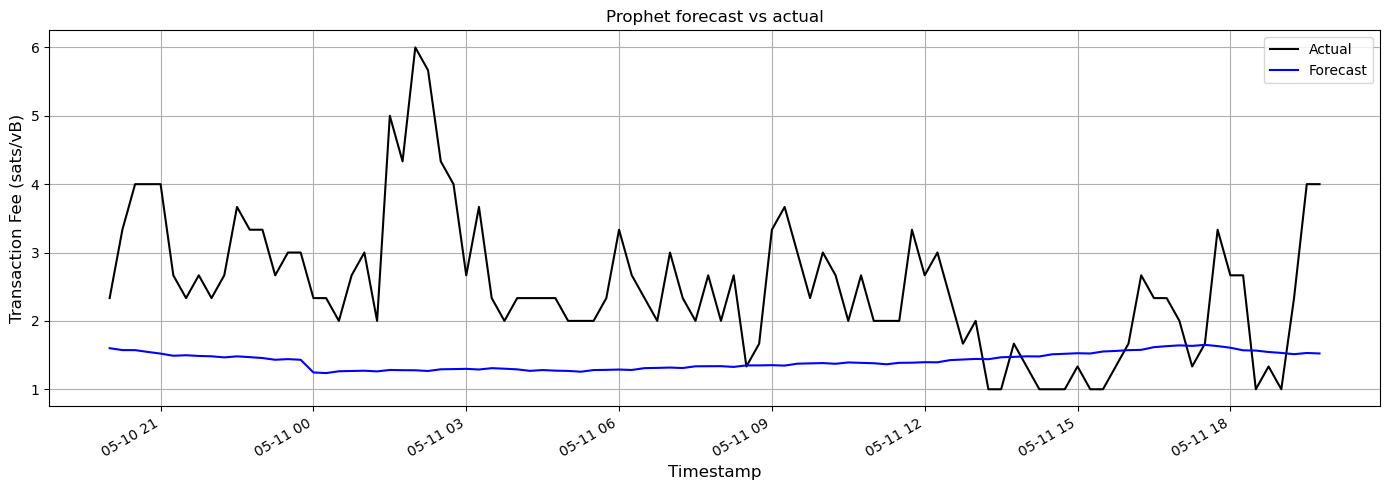

In [19]:
plt.figure(figsize=(12, 5))
plot_series(forecast_prophet, sid = "recommended_fee_fastestFee")
plt.title("Prophet forecast vs actual")
plt.tight_layout()
plt.show()

### Why Is This Step Crucial For Prophet

- **Provides concrete evidence** of model performance under realistic forecasting conditions.
- **Highlights the impact of domain knowledge**: comparing models with and without holidays shows the benefit of event-aware modeling.
- **Supports evaluation from both statistical and operational perspectives** (metrics + visual fit).
- **Confirms volatility handling**: the custom loss helps surface improvements in spike adaptation that standard metrics might miss.
- **Guides model selection** for downstream deployment, based on performance under realistic conditions.

#### Insights from Performance Evaluation

- The final Prophet model—enhanced with congestion-aware holidays and tuned seasonal parameters—demonstrated improved alignment with observed Bitcoin fee dynamics.

- Visual inspection confirmed its ability to track scheduled structural changes and respond to congestion-driven spikes.

- Quantitative evaluation showed that the model with holidays reduced volatility-related error components (e.g., std_diff, dev_error), while preserving low MAE and RMSE.

- These results underscore the value of domain-specific features in boosting model responsiveness during high-volatility regimes.

## 6. Conclusion: Prophet for Bitcoin Fee Forecasting

This notebook implements and evaluates the Prophet model for forecasting Bitcoin transaction fees at 15-minute intervals, focusing on short-term (24-hour) prediction accuracy under volatile network conditions.

**Key steps included:**

- Preprocessing raw mempool data with 15-minute resampling, target selection, and holdout of the final 24 hours for evaluation.

- Converting the dataset into Prophet-compatible format (`ds`, `y`) and removing outliers.

- Defining pseudo-holidays using the top 10% of fee spikes to capture short-lived congestion surges.

- Tuning Prophet’s changepoint and seasonality parameters using grid search for best trend/seasonal flexibility.

- Training two Prophet variants—with and without congestion-aware holidays—and comparing their forecasting accuracy.

- Evaluating models using both standard metrics (MAE, RMSE) and a volatility-sensitive custom loss function.

- Visualizing the forecasts to assess trend tracking, spike responsiveness, and smoothness.

**Key takeaways:**

- Incorporating custom holidays significantly improves model performance during volatile periods, especially in spike-sensitive metrics.

- Prophet effectively models daily and weekly seasonality, but may underreact to high-frequency, high-magnitude surges.

- The model’s interpretability, modularity, and support for domain-informed configuration make it well-suited as a mid-tier solution between classic statistical models and deep learning methods.

These findings support the use of Prophet in hybrid pipelines or real-time forecasting systems, particularly when paired with thoughtful feature engineering and volatility-aware extensions.